In [1]:
from fastTSNE import TSNE, TSNEEmbedding
from fastTSNE.callbacks import ErrorLogger
from fastTSNE.affinity import PerplexityBasedNN, MultiscaleMixture
from fastTSNE import initialization

from examples import utils

import numpy as np
import scipy.sparse as sp
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
import gzip
import pickle

with gzip.open("data/10x_mouse_zheng.pkl.gz", "rb") as f:
    data = pickle.load(f)

x = data["pca_50"]
y = data["CellType1"]

In [3]:
print('Data set contains %d samples with %d features' % x.shape)

Data set contains 1306127 samples with 50 features


In [4]:
np.unique(y)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38])

In [5]:
colors = dict(enumerate(
    ["#FFFF00", "#1CE6FF", "#FF34FF", "#FF4A46", "#008941", "#006FA6", "#A30059",
     "#FFDBE5", "#7A4900", "#0000A6", "#63FFAC", "#B79762", "#004D43", "#8FB0FF", "#997D87",
     "#5A0007", "#809693", "#FEFFE6", "#1B4400", "#4FC601", "#3B5DFF", "#4A3B53", "#FF2F80",
     "#61615A", "#BA0900", "#6B7900", "#00C2A0", "#FFAA92", "#FF90C9", "#B903AA", "#D16100",
     "#DDEFFF", "#000035", "#7B4F4B", "#A1C299", "#300018", "#0AA6D8", "#013349", "#00846F",
     "#372101", "#FFB500", "#C2FFED", "#A079BF", "#CC0744", "#C0B9B2", "#C2FF99", "#001E09",
     "#00489C", "#6F0062", "#0CBD66", "#EEC3FF", "#456D75", "#B77B68", "#7A87A1", "#788D66",
     "#885578", "#FAD09F", "#FF8A9A", "#D157A0", "#BEC459", "#456648", "#0086ED", "#886F4C",
     "#34362D", "#B4A8BD", "#00A6AA", "#452C2C", "#636375", "#A3C8C9", "#FF913F", "#938A81",
     "#575329", "#00FECF", "#B05B6F", "#8CD0FF", "#3B9700", "#04F757", "#C8A1A1", "#1E6E00",
     "#7900D7", "#A77500", "#6367A9", "#A05837", "#6B002C", "#772600", "#D790FF", "#9B9700",
     "#549E79", "#FFF69F", "#201625", "#72418F", "#BC23FF", "#99ADC0", "#3A2465", "#922329",
     "#5B4534", "#FDE8DC", "#404E55", "#0089A3", "#CB7E98", "#A4E804", "#324E72", "#6A3A4C",
     "#83AB58", "#001C1E", "#D1F7CE", "#004B28", "#C8D0F6", "#A3A489", "#806C66", "#222800",
     "#BF5650", "#E83000", "#66796D", "#DA007C", "#FF1A59", "#8ADBB4", "#1E0200", "#5B4E51",
     "#C895C5", "#320033", "#FF6832", "#66E1D3", "#CFCDAC", "#D0AC94", "#7ED379", "#012C58"]
))

In [6]:
def plot(x, y, ax=None, draw_centers=True, colors=None, **kwargs) -> None:
    if ax is None:
        import matplotlib.pyplot as plt
        _, ax = plt.subplots()
    
    point_colors = list(map(colors.get, y))
    ax.scatter(x[:, 0], x[:, 1], s=1, alpha=kwargs.get("alpha", 0.1), c=point_colors, rasterized=True)
    
    if draw_centers:
        cluster_labels = np.unique(y)
        cluster_centers = []
        for cluster_id in cluster_labels:
            cluster_centers.append(np.median(x[y == cluster_id], axis=0))
        cluster_centers = np.vstack(cluster_centers)
        
        cluster_center_colors = list(map(colors.get, cluster_labels))
        ax.scatter(cluster_centers[:, 0], cluster_centers[:, 1],
           s=40, color=cluster_center_colors, edgecolors="k")
    
    ax.set_xticks([]), ax.set_yticks([])
    ax.axis("off")

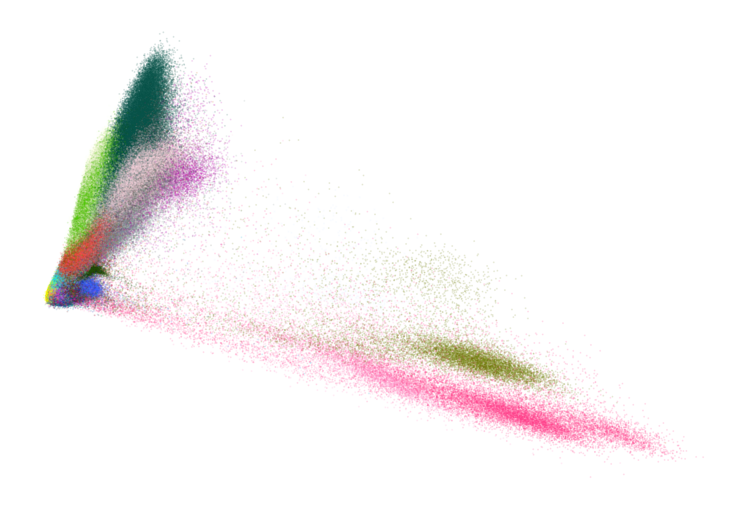

In [7]:
plot(x[:, :2], y, ax=plt.figure(figsize=(13, 9)).gca(), colors=colors, draw_centers=False)

In [8]:
indices = np.random.RandomState(42).permutation(list(range(x.shape[0])))
reverse = np.argsort(indices)

x_sample, y_sample = x[indices[:25000]], y[indices[:25000]]
x_rest, y_rest = x[indices[25000:]], y[indices[25000:]]

In [9]:
%time init = initialization.pca(x_sample)

CPU times: user 1.6 s, sys: 164 ms, total: 1.76 s
Wall time: 76.5 ms


In [10]:
%time affinities = PerplexityBasedNN(x_sample, perplexity=500, method='approx', n_jobs=8)

CPU times: user 7min 59s, sys: 6.87 s, total: 8min 6s
Wall time: 1min 41s


In [11]:
sample_embedding = TSNEEmbedding(
    init, affinities, negative_gradient_method='fft',
    learning_rate=1000, n_jobs=8, callbacks=ErrorLogger(),
)

In [12]:
%time sample_embedding1 = sample_embedding.optimize(n_iter=250, exaggeration=12, momentum=0.5)

Iteration   50, KL divergence  3.0784, 50 iterations in 9.4989 sec
Iteration  100, KL divergence  3.0323, 50 iterations in 9.3528 sec
Iteration  150, KL divergence  3.0286, 50 iterations in 9.3613 sec
Iteration  200, KL divergence  3.0272, 50 iterations in 9.2111 sec
Iteration  250, KL divergence  3.0265, 50 iterations in 9.3822 sec
CPU times: user 17min 41s, sys: 43.8 s, total: 18min 25s
Wall time: 47.4 s


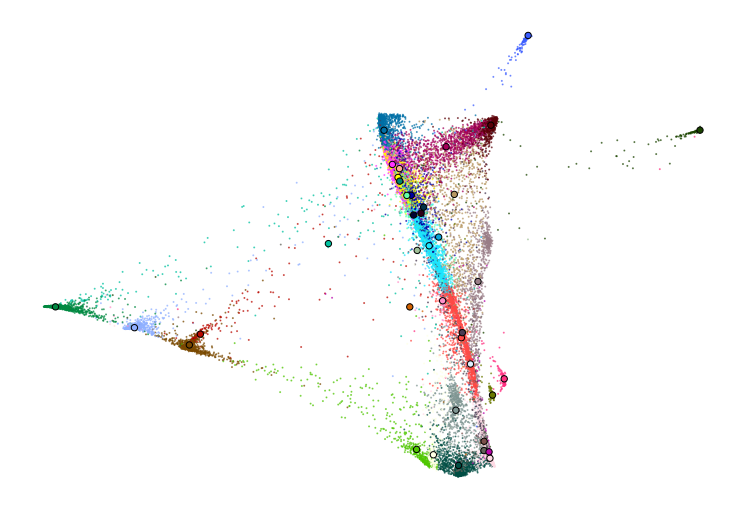

In [13]:
plot(sample_embedding1, y[indices[:25000]], ax=plt.figure(figsize=(13, 9)).gca(), colors=colors, alpha=0.6)

In [14]:
%time sample_embedding2 = sample_embedding1.optimize(n_iter=750, exaggeration=1, momentum=0.8)

Iteration   50, KL divergence  1.3353, 50 iterations in 9.5621 sec
Iteration  100, KL divergence  1.1961, 50 iterations in 9.7298 sec
Iteration  150, KL divergence  1.1582, 50 iterations in 9.7902 sec
Iteration  200, KL divergence  1.1399, 50 iterations in 10.1291 sec
Iteration  250, KL divergence  1.1308, 50 iterations in 10.5489 sec
Iteration  300, KL divergence  1.1260, 50 iterations in 10.7062 sec
Iteration  350, KL divergence  1.1224, 50 iterations in 10.3285 sec
Iteration  400, KL divergence  1.1195, 50 iterations in 10.7226 sec
Iteration  450, KL divergence  1.1172, 50 iterations in 11.4579 sec
Iteration  500, KL divergence  1.1154, 50 iterations in 11.3549 sec
Iteration  550, KL divergence  1.1137, 50 iterations in 10.6164 sec
Iteration  600, KL divergence  1.1127, 50 iterations in 11.1025 sec
Iteration  650, KL divergence  1.1114, 50 iterations in 11.4314 sec
Iteration  700, KL divergence  1.1102, 50 iterations in 10.7256 sec
Iteration  750, KL divergence  1.1098, 50 iteration

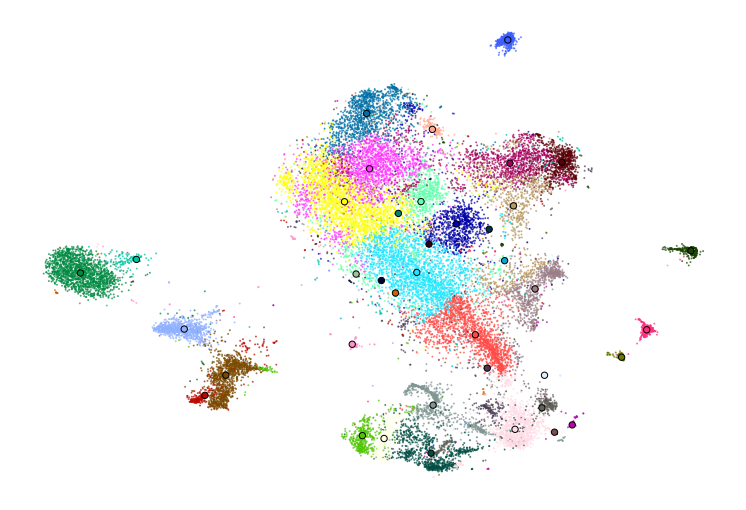

In [15]:
plot(sample_embedding2, y[indices[:25000]], ax=plt.figure(figsize=(13, 9)).gca(), colors=colors, alpha=0.6)

In [16]:
%time rest_init = sample_embedding2.prepare_partial(x_rest, perplexity=1)

CPU times: user 1min 45s, sys: 876 ms, total: 1min 46s
Wall time: 52 s


In [17]:
x_full = np.vstack((x_sample, x_rest))
y_full = np.hstack((y_sample, y_rest))
init_full = np.vstack((sample_embedding2, rest_init))

In [18]:
x_full = x_full[reverse]
y_full = y_full[reverse]
init_full = init_full[reverse]

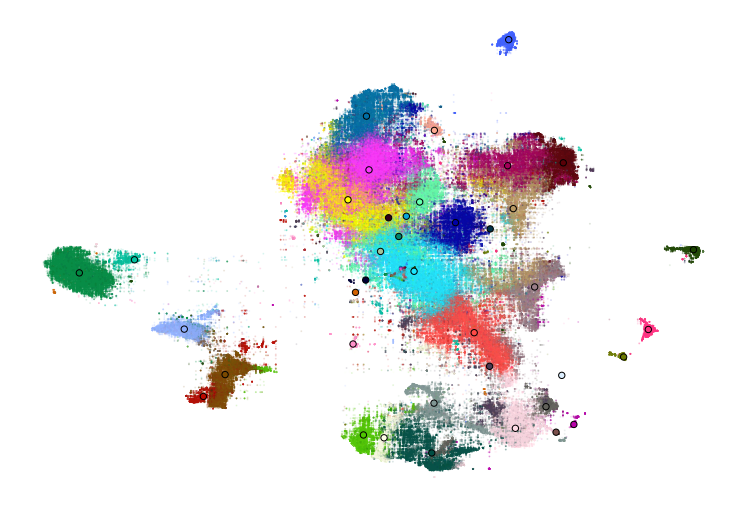

In [19]:
plot(init_full, y, ax=plt.figure(figsize=(13, 9)).gca(), colors=colors)

In [20]:
init_full = init_full / (np.std(init_full[:, 0]) * 10000)
np.std(init_full, axis=0)

array([0.0001    , 0.00011561])

In [21]:
%time full_affinities = PerplexityBasedNN(x_full, perplexity=30, method='approx', n_jobs=8)

CPU times: user 45min 46s, sys: 55.3 s, total: 46min 41s
Wall time: 23min 1s


In [22]:
embedding = TSNEEmbedding(
    init_full, full_affinities, negative_gradient_method='fft',
    learning_rate=1000, n_jobs=16, callbacks=ErrorLogger(),
    min_num_intervals=50, ints_in_interval=1,
)

In [23]:
%time embedding1 = embedding.optimize(n_iter=500, exaggeration=12, momentum=0.5)

Iteration   50, KL divergence  10.2846, 50 iterations in 39.8941 sec
Iteration  100, KL divergence  10.2807, 50 iterations in 38.8984 sec
Iteration  150, KL divergence  9.3277, 50 iterations in 39.0984 sec
Iteration  200, KL divergence  8.7498, 50 iterations in 40.4634 sec
Iteration  250, KL divergence  8.5086, 50 iterations in 39.5226 sec
Iteration  300, KL divergence  8.3825, 50 iterations in 38.5117 sec
Iteration  350, KL divergence  8.3081, 50 iterations in 37.7206 sec
Iteration  400, KL divergence  8.2606, 50 iterations in 37.3547 sec
Iteration  450, KL divergence  8.2284, 50 iterations in 37.3767 sec
Iteration  500, KL divergence  8.2057, 50 iterations in 38.9639 sec
CPU times: user 1h 46min 52s, sys: 3min 34s, total: 1h 50min 26s
Wall time: 6min 29s


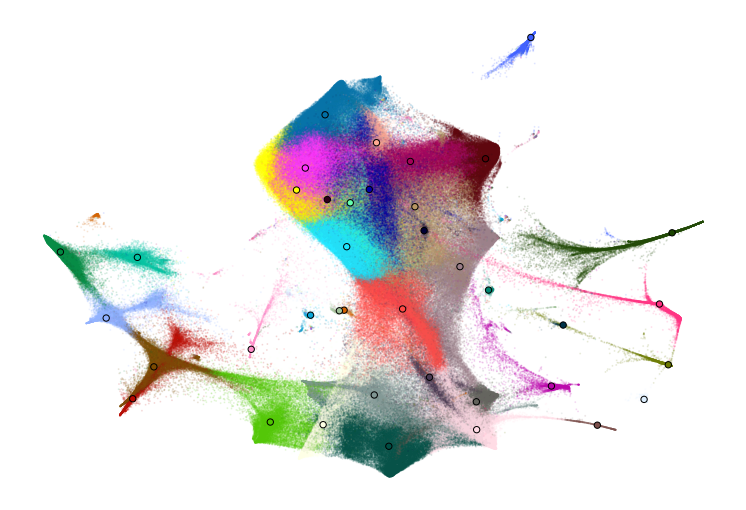

In [24]:
plot(embedding1, y_full, ax=plt.figure(figsize=(13, 9)).gca(), colors=colors)

In [25]:
%time embedding2 = embedding1.optimize(n_iter=250, exaggeration=4, momentum=0.8)

Iteration   50, KL divergence  7.6309, 50 iterations in 44.2215 sec
Iteration  100, KL divergence  7.4533, 50 iterations in 42.1534 sec
Iteration  150, KL divergence  7.3481, 50 iterations in 41.1987 sec
Iteration  200, KL divergence  7.2778, 50 iterations in 40.9044 sec
Iteration  250, KL divergence  7.2277, 50 iterations in 41.5867 sec
CPU times: user 57min 10s, sys: 1min 41s, total: 58min 51s
Wall time: 3min 31s


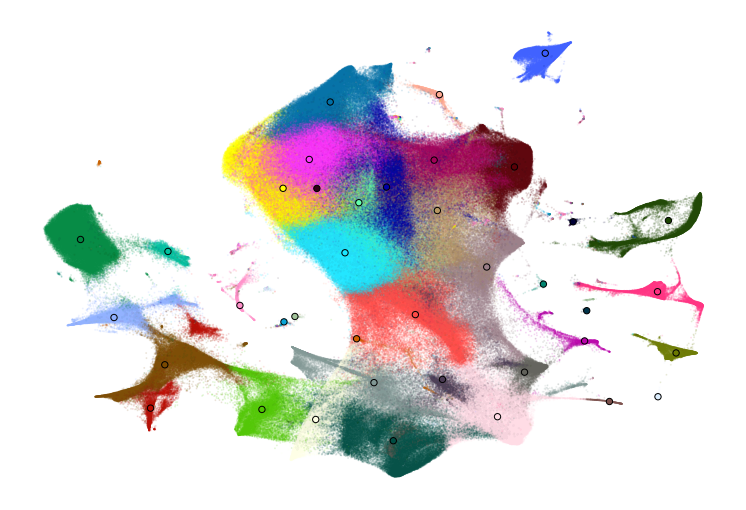

In [26]:
plot(embedding2, y_full, ax=plt.figure(figsize=(13, 9)).gca(), colors=colors)

In [27]:
%time embedding3 = embedding2.optimize(n_iter=250, exaggeration=4, momentum=0.8)

Iteration   50, KL divergence  7.1925, 50 iterations in 39.3623 sec
Iteration  100, KL divergence  7.1620, 50 iterations in 38.7791 sec
Iteration  150, KL divergence  7.1373, 50 iterations in 39.0006 sec
Iteration  200, KL divergence  7.1168, 50 iterations in 37.4706 sec
Iteration  250, KL divergence  7.0991, 50 iterations in 37.0006 sec
CPU times: user 52min 38s, sys: 1min 40s, total: 54min 19s
Wall time: 3min 13s


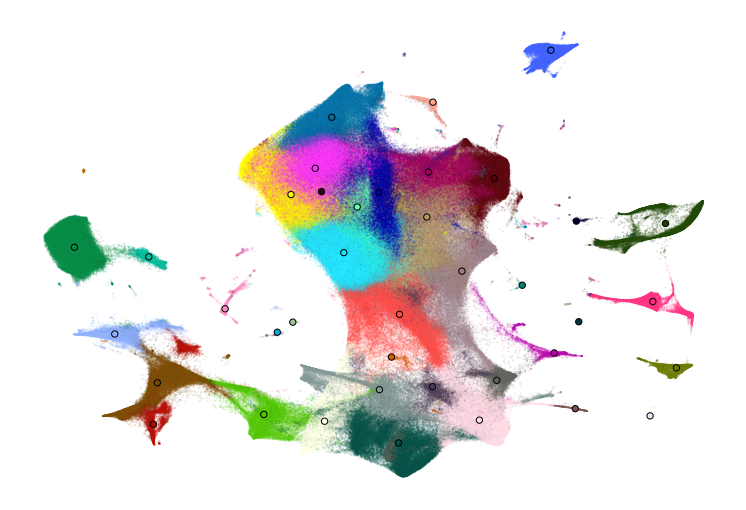

In [28]:
plot(embedding3, y_full, ax=plt.figure(figsize=(13, 9)).gca(), colors=colors)

In [29]:
%time embedding4 = embedding3.optimize(n_iter=250, exaggeration=4, momentum=0.8)

Iteration   50, KL divergence  7.0843, 50 iterations in 36.8024 sec
Iteration  100, KL divergence  7.0691, 50 iterations in 37.0602 sec
Iteration  150, KL divergence  7.0563, 50 iterations in 36.8631 sec
Iteration  200, KL divergence  7.0461, 50 iterations in 37.1539 sec
Iteration  250, KL divergence  7.0379, 50 iterations in 38.6930 sec
CPU times: user 51min 58s, sys: 1min 42s, total: 53min 41s
Wall time: 3min 8s


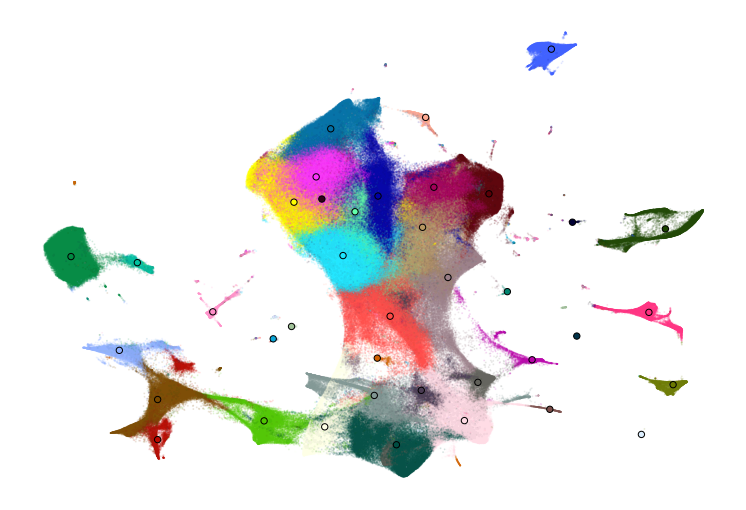

In [30]:
plot(embedding4, y_full, ax=plt.figure(figsize=(13, 9)).gca(), colors=colors)

In [31]:
%time embedding5 = embedding4.optimize(n_iter=250, exaggeration=4, momentum=0.8)

Iteration   50, KL divergence  7.0315, 50 iterations in 39.2106 sec
Iteration  100, KL divergence  7.0252, 50 iterations in 38.9067 sec
Iteration  150, KL divergence  7.0192, 50 iterations in 38.5984 sec
Iteration  200, KL divergence  7.0145, 50 iterations in 40.3227 sec
Iteration  250, KL divergence  7.0101, 50 iterations in 39.2410 sec
CPU times: user 54min 17s, sys: 1min 47s, total: 56min 5s
Wall time: 3min 18s


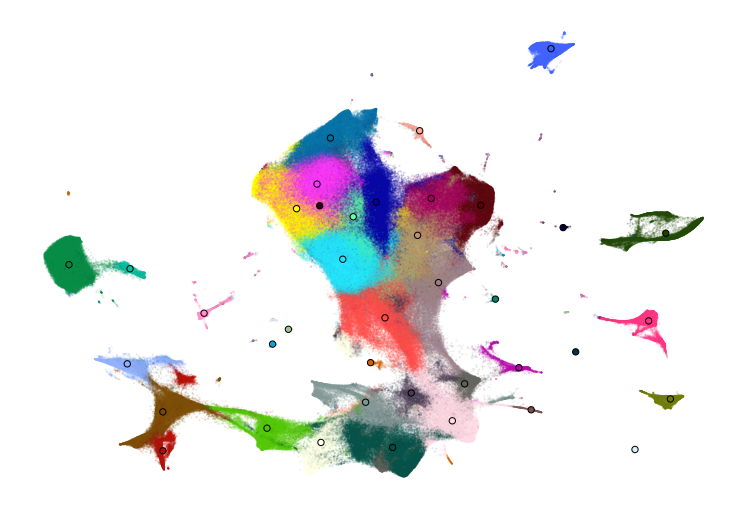

In [32]:
plot(embedding5, y_full, ax=plt.figure(figsize=(13, 9)).gca(), colors=colors)